In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from GraphLaplacian.binary import GraphLaplacian, MBOBinary
from GraphLaplacian.multilabel import GLMultiClass, MBOMultiClass
from GraphLaplacian.helper import plot, plot2d
import pdb
from IPython.display import clear_output
from sklearn.datasets import make_moons, make_circles, make_classification
import scipy
import pdb
from datetime import datetime

matplotlib.rcParams['figure.figsize'] = [5, 5]
sns.set()
sns.set_style("ticks")

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def create_score_sheet(method, y_true, y_pred):
    return {"Method":method, 
            "accuracy":accuracy_score(y_true, y_pred), 
            "f1_score": f1_score(y_true, y_pred, average="weighted"), 
            "presicion": precision_score(y_true, y_pred, average="weighted"), 
            "recall": recall_score(y_true, y_pred, average="weighted")}

In [7]:
def find_h(X, n_sample=5, n_neigh=5, use_mean=False):
    np.random.seed(1000)
    tree = scipy.spatial.cKDTree(X)
    sample = random.sample(X, k=n_sample)
    _func = lambda point: np.mean([x for x in tree.query(point, k = n_neigh+1)[0] if x > 0])
    if use_mean:
        h = np.mean([_func(x) for x in sample])
    else:
        h = np.max([_func(x) for x in sample])
    return h

## Data 1

In [8]:
# Load data from https://www.openml.org/d/554
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [23]:
len(X)

70000

In [24]:
X = X[:2300]/255
Y = [np.int64(y) for y in Y[:2300]]
# to_remove = sum(X) >= 1
# X = np.array([x[to_remove] for x in X])

In [33]:
from sklearn.decomposition import SparsePCA, PCA

In [34]:
pca = SparsePCA(n_components=300)
X_pca = pca.fit_transform(X)

/Users/imam.ar/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


In [27]:
exp_var = pca.explained_variance_ratio_
exp_var_cumsum = np.cumsum(exp_var)
axs = np.array(list(range(len(exp_var)))) + 1

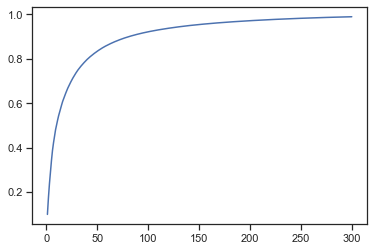

In [28]:
plt.plot(axs, exp_var_cumsum)

In [29]:
N = 300

X0, X1, Y0, Y1 = train_test_split(
    X_pca, Y, train_size=N, test_size=2000 - N)

h = find_h(list(X), len(X), 1, use_mean=False)/3.6
print(h)

2.4018101020323748


In [30]:
len(X0[0])

300

In [31]:
now = datetime.now()
GL = GLMultiClass(list(X0), list(Y0), list(X1), sigma=h)
GL.solve()

print(create_score_sheet("Graph Laplacian", Y1, GL.Y[N:]))
print(datetime.now() - now)

{'Method': 'Graph Laplacian', 'accuracy': 0.5411764705882353, 'f1_score': 0.5376490446957275, 'presicion': 0.8295974476982924, 'recall': 0.5411764705882353}
0:00:34.252326


In [32]:
now = datetime.now()
MBO = MBOMultiClass(list(X0), list(Y0), list(X1), sigma=h, dT=0.005, weight_matrix=GL.weight_matrix)
MBO.solve()

print(create_score_sheet("MBO", Y1,  MBO.Y[N:]))

print(datetime.now() - now)

Creating weight matrix cost 0:00:00.000006
0.8403044676503122
0.003251146357964369
{'Method': 'MBO', 'accuracy': 0.7570588235294118, 'f1_score': 0.7608691856696151, 'presicion': 0.8261433764168183, 'recall': 0.7570588235294118}
0:01:09.691833


In [ ]:
np.sqrt(784)

In [9]:
# Load data from https://www.openml.org/d/554
XX, YY = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
num_row = 2
num_col = 5

num = 10
images = XX[:num]
labels = YY[:num]
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.reshape(images[i], [28,28]), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
scores = list()
for N in [50, 100, 200, 300, 500, 1000]:
    print("Start for N={}".format(N))
    now = datetime.now()
    X = XX[:2000+N]/255
    Y = [np.int64(y) for y in YY[:2000+N]]

    X0, X1, Y0, Y1 = train_test_split(
        X, Y, train_size=N, test_size=2000)

    h = find_h(list(X), len(X), 1, use_mean=False)/3.6

    now = datetime.now()
    GL = GLMultiClass(list(X0), list(Y0), list(X1), sigma=h)
    GL.solve()

    score = create_score_sheet("Graph Laplacian", Y1, GL.Y[N:])
    score["N0"] = N
    score["N"] = N + 2000
    score["model"] = GL
    score["Y1"] = np.array(Y1)
    scores.append(score)
    print(datetime.now() - now)

    now = datetime.now()
    MBO = MBOMultiClass(list(X0), list(Y0), list(X1), sigma=h, dT=0.005, weight_matrix=GL.weight_matrix)
    MBO.solve()

    score = create_score_sheet("MBO", Y1, MBO.Y[N:])
    score["N0"] = N
    score["N"] = N + 2000
    score["model"] = MBO
    score["Y1"] = np.array(Y1)
    scores.append(score)
    print("{} Done in {}".format(N, datetime.now() - now))
    #print(score)

In [ ]:
import pickle

with open("mnist_result", "wb") as f:
    pickle.dump(scores, f)

# with open("mnist_result", "rb") as f:
#     test = pickle.load(f)
    
# print(test)

In [ ]:
df = pd.DataFrame(scores)

In [ ]:
df

In [ ]:
df.pivot(columns="Method", index="N0", values=["f1_score"])

In [ ]:
for s in scores:
    model = s.get("model")
    if s.get("Method") == "Graph Laplacian":
        ax = sns.distplot([max(u) for u in model.U][s.get("N0"):], label=s.get("N0"))
        ax.legend()

In [ ]:
for i, s in enumerate(scores):
    model = s.get("model")
    if s.get("Method") == "Graph Laplacian":
        u_maxs = np.array([max(u) for u in model.U][s.get("N0"):])
        U = model.U[s.get("N0"):]
        #Y1 = np.array(Y[-2000:])
        print(s.get("N0"))
        print("-----")
        for cut in [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            U_ = U[u_maxs >= cut]
            Y_ = np.array(s.get("Y1"))[u_maxs >= cut]
            f1 = f1_score(Y_, np.array([np.argmax(u) for u in U_]), average="weighted")
            acc = accuracy_score(Y_, np.array([np.argmax(u) for u in U_]))
            scores[i]["f1_{}".format(cut)] = {"f1_score":f1, "length":len(U_)}
            print({"u_cut":cut,"f1_score":"{}%".format(round(f1*100,2)), "length":len(U_), "acc":acc})
        print()
        # U_ = U[u_maxs > 0.6]
        

In [ ]:
model.

In [ ]:
np.array([1,2,3])[[True, False, False]]

## Dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components="mle")

In [ ]:
pca.fit_transform()